<a href="https://colab.research.google.com/github/nazizaluxfiati/Deep-Learning/blob/main/AntamStockAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import os
import keras
import tensorflow as tf
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM, GRU
import warnings
from itertools import cycle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings("ignore")

In [50]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [51]:
df = pd.read_csv('/content/drive/MyDrive/Indonesia Stock/ANTM_historical_data.csv')

In [52]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-29,432.588074,436.787964,407.388763,432.588074,278.522797,76180670
1,2005-09-30,457.787384,457.787384,432.588074,457.787384,294.747437,105493978
2,2005-10-03,470.387024,474.586914,440.987854,470.387024,302.859711,59712955
3,2005-10-04,474.586914,482.986694,466.187164,474.586914,305.563843,56236668
4,2005-10-05,482.986694,482.986694,466.187164,482.986694,310.972046,31319315


In [53]:
df.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

In [54]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [55]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [56]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0


In [57]:
df.duplicated().sum()

0

In [58]:
fig = px.line(y=df.Close, x=df.Date)
fig.update_traces(line_color='purple')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Close",
                  title={'text': "Close History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='lightblue')

In [59]:
test_size = df[df.Date.dt.year==2020].shape[0]
test_size

242

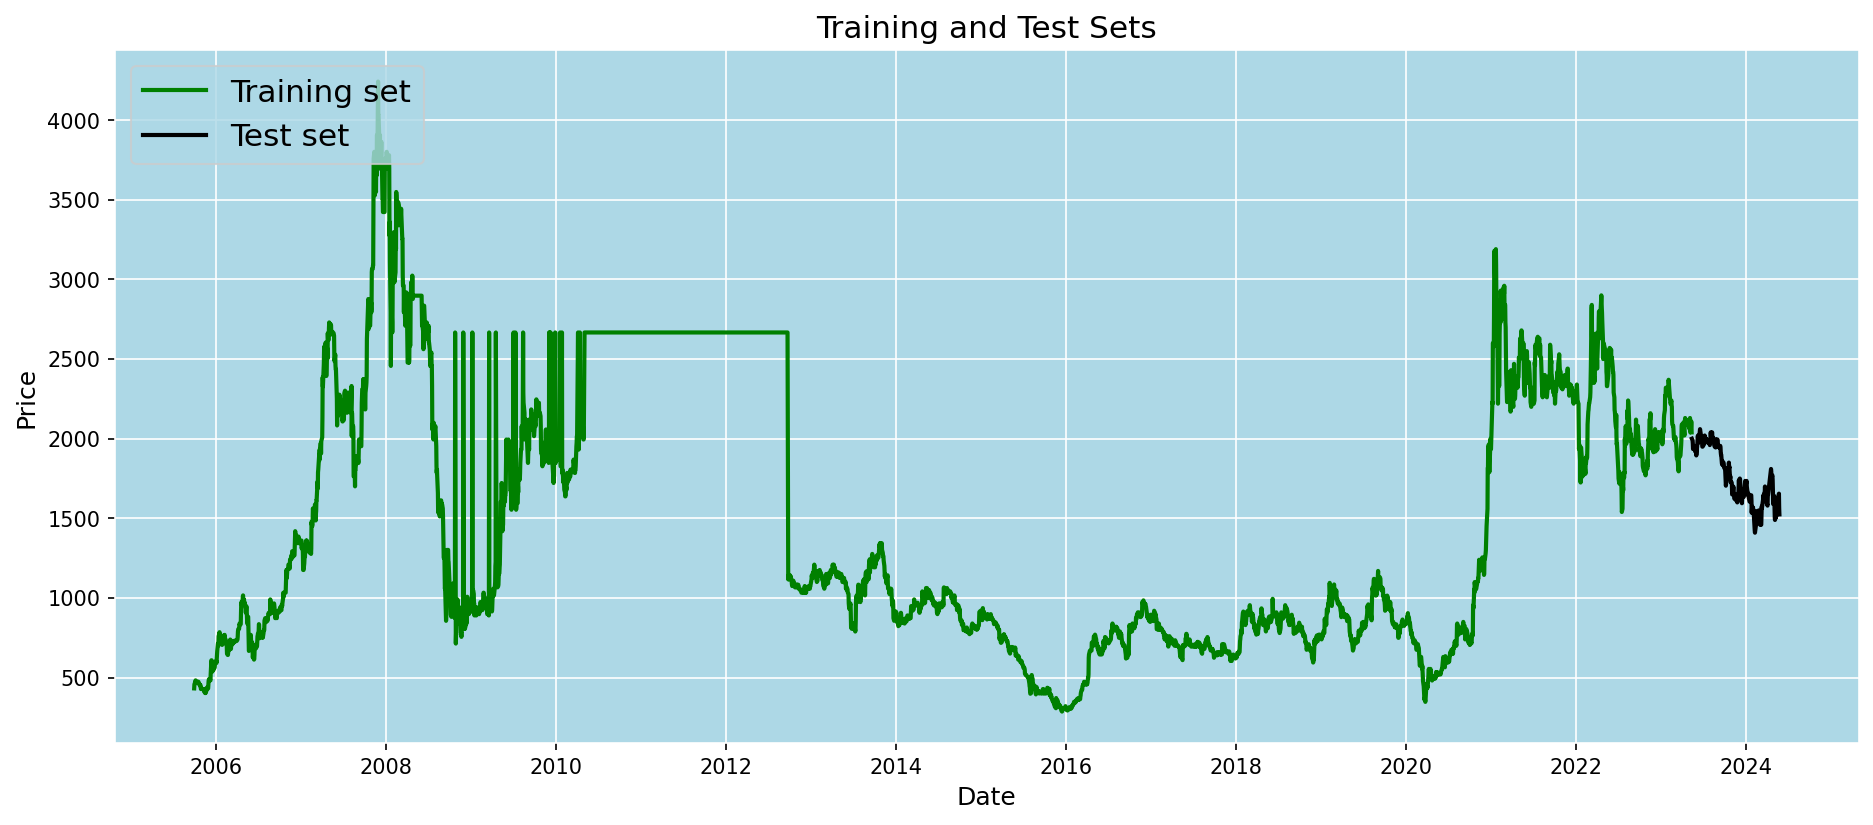

In [60]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'lightblue'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Close[:-test_size], color='green', lw=2)
plt.plot(df.Date[-test_size:], df.Close[-test_size:], color='black', lw=2)
plt.title('Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [61]:
scaler = MinMaxScaler()
scaler.fit(df.Close.values.reshape(-1,1))

MinMaxScaler()

In [62]:
window_size = 60

In [63]:
train_data = df.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [64]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [65]:
test_data = df.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [66]:
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (4362, 1)
test_data:  (302, 1)


In [67]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [68]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [69]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [70]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (4302, 60, 1)
y_train Shape:  (4302, 1)
X_test Shape:   (242, 60, 1)
y_test Shape:   (242, 1)


In [71]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [72]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0359 - val_loss: 0.0043
Epoch 2/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 3/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 4/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 5/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0019 - val_loss: 8.0634e-04
Epoch 6/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0017 - val_loss: 7.4909e-04
Epoch 8/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0015 - val_loss: 6.8650e-04
Epoch 10/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0014 - val_loss: 7.0566e-04
Epoch 12/150
1

In [73]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6349e-04 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [74]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [75]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.00027545279590412974
Test MAPE: 0.037334809527824094
Test Accuracy: 0.9626651904721759


In [76]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

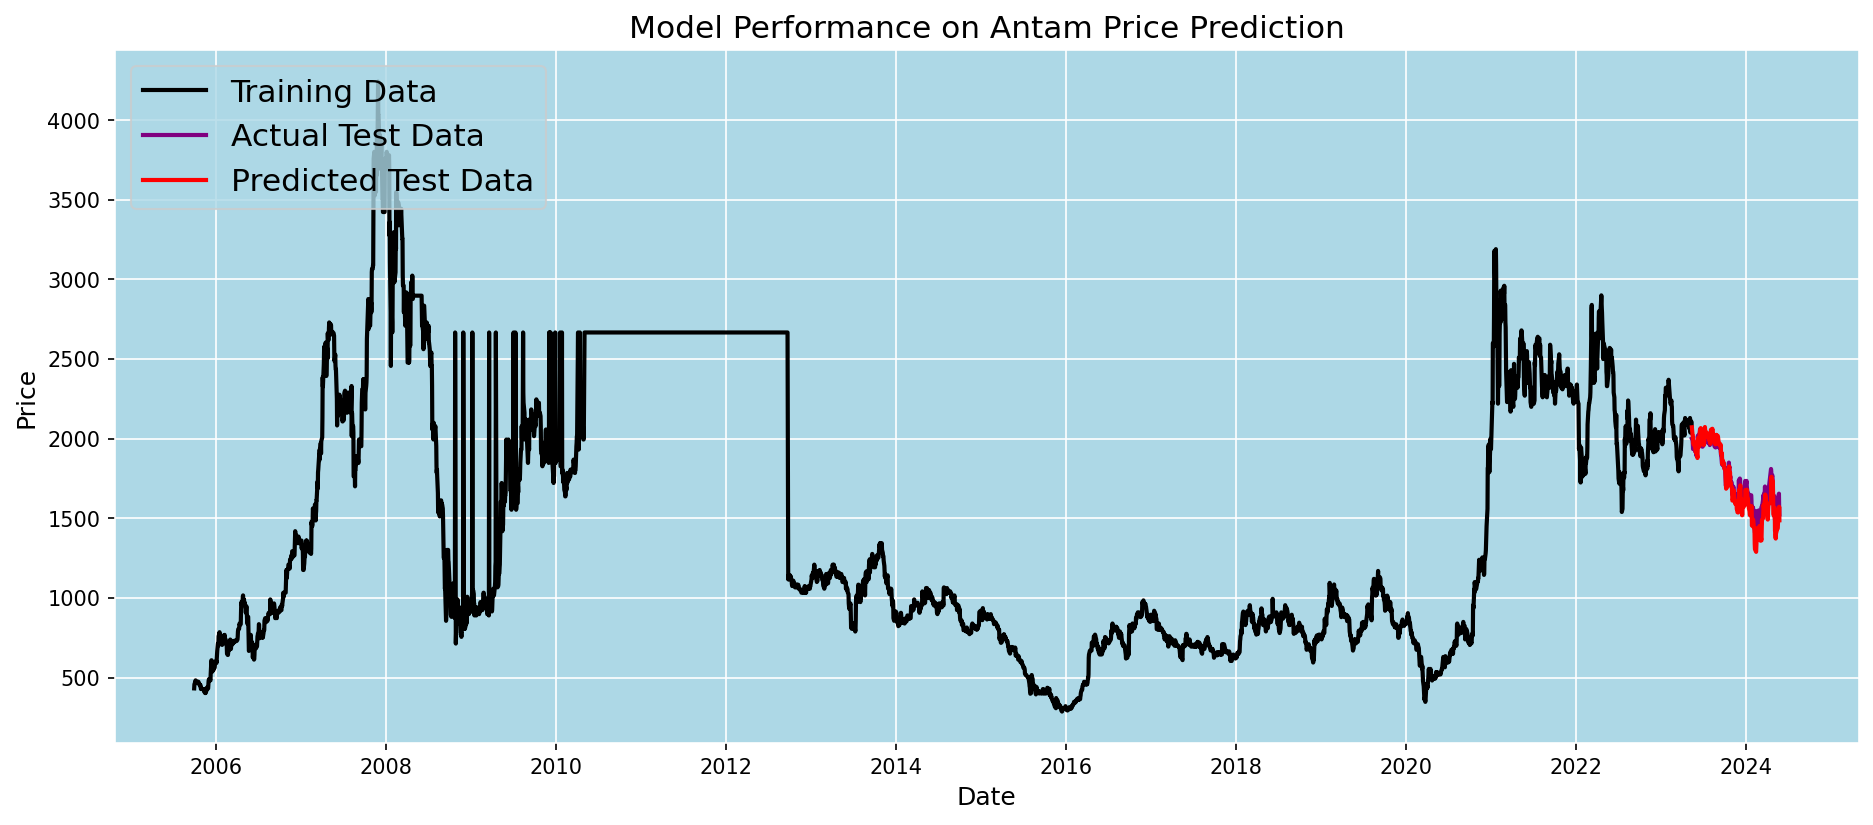

In [77]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'lightblue'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='purple', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Antam Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()


In [78]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [79]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (4346, 15)
y_train:  (4346,)
X_test:  (286, 15)
y_test (286,)


In [80]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [81]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 15, 32)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 15, 32)              │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,065 (62.75 KB)

 Trainable params: 16,065 (62.75 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0281 - val_loss: 4.0120e-04
Epoch 2/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0022 - val_loss: 1.6733e-04
Epoch 3/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 2.9212e-04
Epoch 4/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 1.8205e-04
Epoch 5/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - val_loss: 3.3640e-04
Epoch 6/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - val_loss: 1.2427e-04
Epoch 7/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 1.5315e-04
Epoch 8/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 1.9754e-04
Epoch 9/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - val_loss: 1.0452e-04
Epoch 10/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - val_loss: 1.4549e-04
Epoch 11/200
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 9.7016

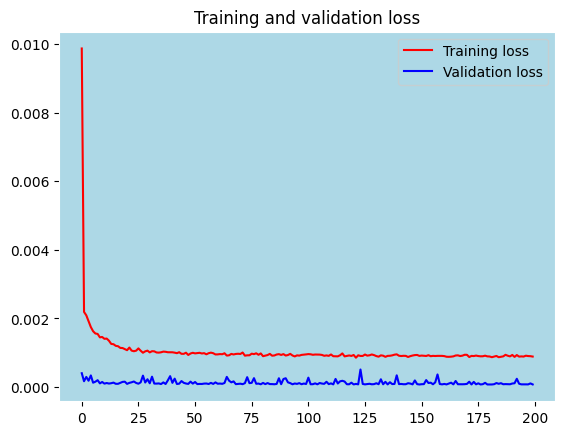

<Figure size 640x480 with 0 Axes>

In [83]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [84]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4237e-05 


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [85]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [86]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 7.3587303631939e-05
Test MAPE: 0.016587737262968673
Test Accuracy: 0.9834122627370313


In [87]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


((4346, 1), (286, 1))

In [88]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [91]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  88.07569835084918
Train data MSE:  7757.328639989778
Train data MAE:  31.28261163591704
-------------------------------------------------------------------------------------
Test data RMSE:  33.926195251850615
Test data MSE:  1150.986724266691
Test data MAE:  24.500585169225303


In [92]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9891423441130787
Test data explained variance regression score: 0.9693877436106589


In [93]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9890580552263053
Test data R2 score: 0.9688320252112098


In [96]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0032506382654176238
Test data MGD:  0.00038117100336596357
----------------------------------------------------------------------
Train data MPD:  4.638922378888317
Test data MPD:  0.6586142513772651
